## Vamos trabalhar com os dados abertos do ONS - Operador Nacional do Sistema Elétrico.

### Optei por trabalhar com os dados de Carga de Energia. Definição conforme site: [Dados de carga por subsistema numa data de referência em base diária](https://dados.ons.org.br/dataset/carga-energia)

### Nessa etapa final do projeto, exploraremos algumas informações da base de dados

### Load das bibliotecas e definição do contexto spark

In [14]:
import pyspark

from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from random import randint
import pandas as pd

In [2]:
sc = SparkContext.getOrCreate()

spark = (SparkSession
      .builder
      .getOrCreate()
     )

print('ApplicationID:', sc.applicationId)

21/09/27 20:18:14 WARN Utils: Your hostname, sambss-IdeaPad resolves to a loopback address: 127.0.1.1; using 192.168.15.200 instead (on interface wlp0s20f3)
21/09/27 20:18:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/09/27 20:18:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


ApplicationID: local-1632784695914


### Caminhos de Leitura e Load da base

In [3]:
read_path = '../data/refined/03_enriquecimento'

In [4]:
df = spark.read.parquet(read_path)

print(f'Número de registros: {df.count()}')

df.printSchema()

Número de registros: 31649
root
 |-- id_medicao: integer (nullable = true)
 |-- nom_subsistema: string (nullable = true)
 |-- id_subsistema: byte (nullable = true)
 |-- val_cargaenergiamwmed: double (nullable = true)
 |-- din_instante: date (nullable = true)
 |-- mes: integer (nullable = true)
 |-- ano: integer (nullable = true)



### Iniciamos com a distribuição ao longo dos anos. 2013 Aparenta possuir um registro a mais que o esperado. Vamos verificar essa informação
- Anos bissextos apresentam 1464 registros, não bissexto, 1460. 2013 Possui 1461. Vamos verificar qual dia possui dois registros a mais para uma mesma região.
- A data 02-02-2013 apresenta 5 registros ao invés de 4.
- Há dois registros do 'id_subsistema' para esse data. Um deles possui 'val_cargaenergiamwmed' nula.

In [5]:
df.groupBy(F.col('ano')).count().orderBy(F.col('ano')).show(30)

+----+-----+
| ano|count|
+----+-----+
|2000| 1464|
|2001| 1460|
|2002| 1460|
|2003| 1460|
|2004| 1464|
|2005| 1460|
|2006| 1460|
|2007| 1460|
|2008| 1464|
|2009| 1460|
|2010| 1460|
|2011| 1460|
|2012| 1464|
|2013| 1461|
|2014| 1460|
|2015| 1460|
|2016| 1464|
|2017| 1460|
|2018| 1460|
|2019| 1460|
|2020| 1464|
|2021|  964|
+----+-----+



In [6]:
df.filter(F.col('ano') == 2013).groupBy('din_instante').count().orderBy(F.col('count').desc()).show(5)

+------------+-----+
|din_instante|count|
+------------+-----+
|  2013-02-02|    5|
|  2013-09-09|    4|
|  2013-09-12|    4|
|  2013-01-22|    4|
|  2013-03-26|    4|
+------------+-----+
only showing top 5 rows



In [7]:
df.filter(F.col('din_instante') == '2013-02-02').show()

+----------+--------------+-------------+---------------------+------------+---+----+
|id_medicao|nom_subsistema|id_subsistema|val_cargaenergiamwmed|din_instante|mes| ano|
+----------+--------------+-------------+---------------------+------------+---+----+
|     19125|         NORTE|            1|             4040.475|  2013-02-02|  2|2013|
|     19126|      NORDESTE|            2|          9197.529875|  2013-02-02|  2|2013|
|     19127|           SUL|            3|       10941.04154167|  2013-02-02|  2|2013|
|     19128|           SUL|            3|                 null|  2013-02-02|  2|2013|
|     19129|       SUDESTE|            4|         34397.934625|  2013-02-02|  2|2013|
+----------+--------------+-------------+---------------------+------------+---+----+



### Assim como o registro analisado, outros possuem valor nulo para 'val_cargaenergiamwmed'. Abaixo estão listados esses registros

In [8]:
df.filter(F.col('val_cargaenergiamwmed').isNull()).show()

+----------+--------------+-------------+---------------------+------------+---+----+
|id_medicao|nom_subsistema|id_subsistema|val_cargaenergiamwmed|din_instante|mes| ano|
+----------+--------------+-------------+---------------------+------------+---+----+
|     19128|           SUL|            3|                 null|  2013-02-02|  2|2013|
|     20582|         NORTE|            1|                 null|  2014-02-01|  2|2014|
|     20583|      NORDESTE|            2|                 null|  2014-02-01|  2|2014|
|     20584|           SUL|            3|                 null|  2014-02-01|  2|2014|
|     20585|       SUDESTE|            4|                 null|  2014-02-01|  2|2014|
|     31638|         NORTE|            1|                 null|  2021-08-27|  8|2021|
|     31639|      NORDESTE|            2|                 null|  2021-08-27|  8|2021|
|     31640|           SUL|            3|                 null|  2021-08-27|  8|2021|
|     31641|       SUDESTE|            4|             

### Análise Geral de 'val_cargaenergiamwmed'
- Mínimo
- Máximo
- Média
- Desvio Padrão

In [9]:
df.agg(F.min(F.col('val_cargaenergiamwmed')).alias('min'),
      F.max(F.col('val_cargaenergiamwmed')).alias('max'),
      F.mean(F.col('val_cargaenergiamwmed')).alias('mean'),
      F.stddev(F.col('val_cargaenergiamwmed')).alias('stdev')).show()

+-------------+-----------+------------------+------------------+
|          min|        max|              mean|             stdev|
+-------------+-----------+------------------+------------------+
|1852.02083333|46700.40475|13375.566746478418|11430.088100677169|
+-------------+-----------+------------------+------------------+



### Análise Geral de 'val_cargaenergiamwmed' por região
- Mínimo
- Máximo
- Média
- Desvio Padrão

In [10]:
df.groupBy('id_subsistema').agg(F.min(F.col('val_cargaenergiamwmed')).alias('min'),
      F.max(F.col('val_cargaenergiamwmed')).alias('max'),
      F.mean(F.col('val_cargaenergiamwmed')).alias('mean'),
      F.stddev(F.col('val_cargaenergiamwmed')).alias('stdev')).orderBy('id_subsistema').show()

+-------------+--------------+--------------+------------------+------------------+
|id_subsistema|           min|           max|              mean|             stdev|
+-------------+--------------+--------------+------------------+------------------+
|            1| 1852.02083333|     6779.2955| 4053.623779164803| 1156.288926006875|
|            2|      3904.475|13536.63062792|8187.4521357520625|1862.4059885690322|
|            3| 4465.69125137|  15645.296125| 9116.678037705053|2065.8125687385495|
|            4|15878.38583333|   46700.40475| 32144.51303329187| 5410.749594449195|
+-------------+--------------+--------------+------------------+------------------+



### Podemos obter essas informações para cada ano

In [11]:
ano_desejado = 2003

ano_desejado += 1
for ano in range(2000,ano_desejado):
    print(f'Análise de {ano}:\n')
    df_ano = df.filter(F.col('ano') == ano)
    
    df_ano.agg(F.min(F.col('val_cargaenergiamwmed')).alias('min'),
      F.max(F.col('val_cargaenergiamwmed')).alias('max'),
      F.mean(F.col('val_cargaenergiamwmed')).alias('mean'),
      F.stddev(F.col('val_cargaenergiamwmed')).alias('stdev')).show()
    
    print(f'Análise por região:')
    
    df_ano.groupBy('id_subsistema').agg(F.min(F.col('val_cargaenergiamwmed')).alias('min'),
      F.max(F.col('val_cargaenergiamwmed')).alias('max'),
      F.mean(F.col('val_cargaenergiamwmed')).alias('mean'),
      F.stddev(F.col('val_cargaenergiamwmed')).alias('stdev')).orderBy('id_subsistema').show()
    print(100 * '-', '\n')

Análise de 2000:

+-------------+--------------+------------------+-----------------+
|          min|           max|              mean|            stdev|
+-------------+--------------+------------------+-----------------+
|2232.45416667|29569.82916667|10202.946119678696|9174.912131075394|
+-------------+--------------+------------------+-----------------+

Análise por região:
+-------------+--------------+--------------+------------------+------------------+
|id_subsistema|           min|           max|              mean|             stdev|
+-------------+--------------+--------------+------------------+------------------+
|            1| 2232.45416667|     2670.9625| 2486.946410964508| 99.96132748417685|
|            2| 4485.20833333| 6747.90833333| 5862.865607923249|392.52421876531855|
|            3|       4800.65|     8102.8375|6736.2913908193705| 751.7870962393797|
|            4|19045.99583333|29569.82916667| 25725.68106900767|2103.5538022171354|
+-------------+--------------+---

### Outra possibilidade é verificar a mudança no consumo de energia em um determinado mês ao longo dos anos.

In [13]:
# Avaliaremos, neste caso, o mês de Janeiro (01)
mes = 1

df_mes = df.filter(F.col('mes') == mes)

df.groupBy(F.col('ano')).agg(F.min(F.col('val_cargaenergiamwmed')).alias('min'),
      F.max(F.col('val_cargaenergiamwmed')).alias('max'),
      F.mean(F.col('val_cargaenergiamwmed')).alias('mean'),
      F.stddev(F.col('val_cargaenergiamwmed')).alias('stdev')).orderBy(F.col('ano')).show(30)

+----+-------------+--------------+------------------+------------------+
| ano|          min|           max|              mean|             stdev|
+----+-------------+--------------+------------------+------------------+
|2000|2232.45416667|29569.82916667|10202.946119678696| 9174.912131075394|
|2001|1852.02083333|29754.89291667| 9431.322592151908| 8373.392233091807|
|2002|1927.36666667|29207.56833318| 9915.818331899138| 8944.382048071051|
|2003|    2313.3375|30100.37000224|10439.936581078759| 9265.901851373761|
|2004|    2676.6125|30947.97874985|10931.681881722756| 9625.415788611326|
|2005|2763.85416667|32190.82291595|11427.088372745451| 9996.013940535953|
|2006|3019.30666667|32879.37754167| 11866.44984654193|10316.405739049138|
|2007|3104.37958333|34835.76916667|12431.233749172408|10860.171488526996|
|2008|3158.84208333|35905.64458333|12750.575695013702|11046.944459279834|
|2009|3205.83416667|36738.17041667|12648.075568914266|10907.094652673079|
|2010| 3392.9102586|   38843.28125|135

In [19]:
# Coleta das médias no mês de Janeiro para visualização

lista_media = df_mes.groupBy(F.col('ano')).agg(
    F.mean(F.col('val_cargaenergiamwmed')).alias('mean')).orderBy(F.col('ano')).collect()

lista_media = [[x[0], round(x[1], 2)] for x in lista_media]

In [20]:
lista_media

[[2000, 9813.35],
 [2001, 10616.09],
 [2002, 9124.75],
 [2003, 10371.83],
 [2004, 10580.99],
 [2005, 11331.39],
 [2006, 11925.02],
 [2007, 12292.35],
 [2008, 12719.11],
 [2009, 12197.76],
 [2010, 13538.17],
 [2011, 14103.97],
 [2012, 14494.54],
 [2013, 14551.07],
 [2014, 16355.53],
 [2015, 16807.51],
 [2016, 15637.1],
 [2017, 16614.44],
 [2018, 16632.92],
 [2019, 17799.23],
 [2020, 17135.31],
 [2021, 17473.44]]

In [43]:
df_pd = pd.DataFrame(data= lista_media, columns=['ano', 'consumo_medio'])
df_pd = df_pd.set_index('ano')

<AxesSubplot:xlabel='ano'>

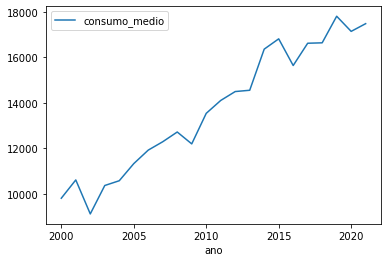

In [47]:
df_pd.plot()

In [ ]:
sc.stop()